# Multilevel Bayesian Correlations

TODO: INTRODUCTION

## Outline
* [Pearson Correlation](#pearson-correlation)
* [Multilevel Correlation](#multilevel-correlation)
* [Robust Correlation](#robust-correlation)
* [Correlating School Funding with Student Performance](#real-data)
* [Simplifications](#simplifications)



First let's load the packages we'll need, and set some settings.

In [1]:
# Packages
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sb
import pystan
from scipy.stats import pearsonr

# Plot settings
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
sb.set()

# Settings for Stan
Niters = 1000
Nchains = 5

## Pearson Correlation
<a class="anchor" id="pearson-correlation"></a>

The Pearson correlation coefficient ($\rho$) is a measure of how correlated two variables are (e.g. $X_1$ and $X_2$), and is the ratio of the true covariance of the two variables to their expected covariance if they were perfectly correlated:

$$
\rho_{X_1,X_2} = \frac{\text{cov}(X_1,X_2)}{\sigma_{X_1} \sigma_{X_2}}
$$

where
* $\text{cov}(X_1, X_2)$ is the covariance between $X_1$ and $X_2$
* $\sigma_{X_1}$ is the standard deviation of $X_1$, and 
* $\sigma_{X_2}$ is the standard deviation of $X_2$

This coefficient ranges between 1 (when the two variables are perfectly positively correlated) and -1 (when they are perfectly negatively correlated), and a coefficient value of 0 means that there is no correlation.

Let's generate some data which we *know* displays a positive correlation between two variables:

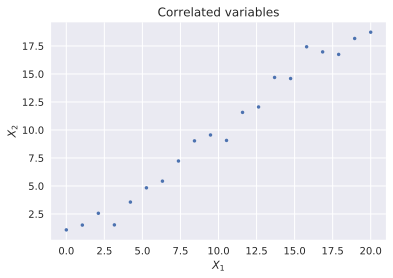

In [4]:
# Create some dummy data with known correlation
X = np.zeros((20,2))
X[:,0] = np.linspace(0, 20, 20)
X[:,1] = X[:,0] + np.random.randn(20)

# Plot dummy data
plt.figure()
plt.plot(X[:,0], X[:,1], '.')
plt.xlabel(r'$X_1$')
plt.ylabel(r'$X_2$')
plt.title('Correlated variables')
plt.show()

We can compute the maximum likelihood estimate of $\rho$ (that is, the correlation coefficient value which is most likely) by using the equation above.  The `scipy.stats` package also provides a function for computing $\rho$, along with a p-value which tells us the probability of getting that value for $\rho$ if there were no correlation at all. 

In [9]:
# Compute Pearson correlation coefficient
from scipy.stats import pearsonr
rho, pval = pearsonr(X[:,0], X[:,1])
print('Correlation coefficient: %0.3g ( p = %0.3g )' % (rho, pval))

Correlation coefficient: 0.99 ( p = 1.19e-16 )


But what if we want to know the probability of seeing *any* value of $\rho$?  If we could compute a probability distribution over the possible values $\rho$ could take, then we would be able to make inferences as to the value of $\rho$.  What I mean by "inferences" is statements such as "there's a 95% probability that the value of $\rho$ is between 0.3 and 0.6".  Using frequentist statistics (which gave us the p-value above), we can only make claims like "assuming there is no correlation, the probability of observing our data is such-and-such."  Having a full probability distribution over the values of $\rho$ would give us a more explicit way of expressing how uncertain we are about the value of $\rho$, and also would let us understand how likely different effect sizes are.

To get that probability distribution, we can perform a Bayesian correlation.  Basically what we'll be doing is "fitting" a bivariate (2D) normal distribution to our points, and then computing $\rho$ from the covariance of that normal distribution. 

![Fitting a normal distribution](https://brendanhasz.github.io/assets/img/bayesian-correlation/fitting-normal-distribution.svg)

A univariate (1D) normal distribution is defined by its mean and variance.  But a bivariate normal distribution is defined by its mean *vector* $\mu$ (i.e. the mean in each dimension ) and its covariance matrix (the covariance between each pair of dimensions).  The covariance matrix for a bivariate normal distribution is just a 2x2 matrix, and people usually use the symbol $\Sigma$ to refer to it (not to be confused with the same symbol which is used for a sum!).  The diagonal elements of the matrix are just the variance of the data in each dimension, and the non-diagonal elements are the covariance between dimensions:

$$
\Sigma = 
\begin{bmatrix}
    \text{cov}(X_1,X_1) & \text{cov}(X_1,X_2) \\
    \text{cov}(X_1,X_2) & \text{cov}(X_2,X_2) 
\end{bmatrix}
$$

again where $\text{cov}(A, B)$ is the covariance between $A$ and $B$ (and the variance if $A$ and $B$ are the same).  Then the probability value of that distribution at any $x,y$ location can be computed:

$$
\mathcal{N}(x,\mu,\Sigma) = \frac{\text{exp}(-\frac{1}{2} (x-\mu)^T \Sigma^{-1} (x-\mu))}{\sqrt{(2 \pi)^2 | \Sigma |}}
$$

When the covariance is more positive, the distribution is stretched out in a positive direction, and when it is more negative, the distribution is stretched in the negative direction:

![Different rho values](https://brendanhasz.github.io/assets/img/bayesian-correlation/rho-covariance.svg)

Notice that the Pearson correlation coefficient ($\rho$) also tells us how stretched out the normal distribution is - and in which direction!  This is because the Pearson correlation coefficient is defined by the covariance values (relative to the variances).  If we rearrange the equation for $\rho$,

$$
\text{cov}(X_1,X_2) = \rho_{X_1,X_2} \sigma_{X_1} \sigma_{X_2}
$$

then we can re-define the covariance matrix using only the variances ($\sigma_{X_1}$ and $\sigma_{X_2}$) and $\rho$:

$$
\Sigma = 
\begin{bmatrix}
   \sigma_{X_1} \sigma_{X_1} & \rho ~ \sigma_{X_1} \sigma_{X_2} \\
    \rho ~ \sigma_{X_1} \sigma_{X_2} & \sigma_{X_2} \sigma_{X_2} 
\end{bmatrix}
$$

(This also depends on the fact that the variance is equal to the square of the standard deviation, i.e. $\text{cov}(X_1,X_1) = \sigma_{X_1} \sigma_{X_1}$)

Now that we know how to compute $\rho$ from a normal distribution (and vice-versa), we can fit a normal distribution to our data in a Bayesian way.  I've been describing the problem as if we first fit a normal distribution, and then compute $\rho$ from that distribution.  However with Bayesian models, it's usually useful to think of things the other way around: *given* a certain value of $\rho$, we'll compute what the normal distribution should be, and then we'll compute the likelihood that our data came from that distribution.  That way we can test different values of $\rho$ and see how likely or unlikely they are to explain our data!

We're going to use [Stan](http://mc-stan.org/) for defining and fitting our Bayesian model.  Stan is a platform for Bayesian modelling, which lets you use a relatively simple programming language to define your Bayesian model.  Stan then fits your model to your data, returning the posterior probability distributions for your parameter(s) of interest.  The code for a Stan model consists of 3 main blocks (and we're going to also use 1 additional optional block).

First is the "data" block, where we will define what data we're trying to fit.  

Second is the "parameters" block, where we will define what parameters our model uses.  In our case the model's parameters are $\rho$ (the Pearson correlation coefficient), $\mu$ (the vector of means in each dimension for the normal distribution), and $\sigma$ (the vector of standard deviations in each dimension).

The third (optional) block that we'll use is the "transformed parameters" block.  We'll use this block to compute the covariance matrix from $\rho$ and $\sigma$, as described above.

Finally, the last block is the "model" block.  Here we'll define how to compute the probability of the data given the parameters.  As described above, we're just modeling our datapoints as being drawn from a normal distribution (which is defined by $\rho$, $\mu$, and $\sigma$).  Stan provides a simple syntax for modeling the likelihood that certain datapoints were drawn from a distribution: `data ~ distribution(parameters)`.

Let's define the Stan code, compile the model, and fit it to our data.

In [58]:
#STAN code string for a basic pearson correlation
PearsonCorrelation = """
data {
    int<lower=0> N; //number of datapoints
    vector[2] X[N]; //datapoints
}

parameters {
    vector[2] mu;               //mean
    vector<lower=0>[2] sig;     //std dev of each variable
    real<lower=-1,upper=1> rho; //Pearson's rho
}

transformed parameters {
    // Compute the covariance matrix from rho and sigmas
    cov_matrix[2] C;
    C[1,1] = sig[1] * sig[1];
    C[1,2] = rho * sig[1] * sig[2];
    C[2,1] = rho * sig[1] * sig[2];
    C[2,2] = sig[2] * sig[2];
}

model {
    // Model our data as being drawn from multivariate normal 
    // distribution with mean mu and covariance matrix C
    X ~ multi_normal(mu, C);
}
"""

In [59]:
# Compile the Stan model
model_pc = pystan.StanModel(model_code=PearsonCorrelation)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5fe00a7d88522e46825f0c82ee39fe6c NOW.


In [ ]:
# Data for Stan
data = {'N' : X.shape[0], #number of datapoints
        'X' : X} #the data

# Fit the model
fit = model_pc.sampling(data=data, iter=Niters, chains=Nchains, n_jobs=Nchains)

Now that we've fit the model, we can take a look at the estimated parameter values and 95% confidence intervals:

In [ ]:
# Print the results of the fit
print(fit)

But getting the 95% confidence intervals is something we could also do with frequentist statistics.  Now let's get the full posterior distributions (a histogram of the MCMC samples) and plot those full distributions.  We'll plot the posterior distribution for $\rho$, and also the distributions for $\mu$ and $\sigma$, just to make sure our model isn't doing anything crazy.

In [ ]:
# Get the MCMC samples (draws from the posterior distribution)
samples = fit.extract()

In [ ]:
# Plot the posterior distribution for the correlation coefficient
plt.figure()
sb.distplot(samples['rho'])
plt.xlabel('Pearson Correlation Coefficient')
plt.ylabel('Posterior Probability')
plt.show()

In [ ]:
# Plot the posterior joint distribution for the means of the gaussian
plt.figure()
sb.kdeplot(samples['mu'][:,0], samples['mu'][:,1], 
           shade=True, shade_lowest=False, cbar=True)
plt.xlabel(r'$X_1$ Mean')
plt.ylabel(r'$X_2$ Mean')
plt.title('Posterior Joint Distribution of the Means')
plt.show()

In [ ]:
# Plot the posterior joint distribution for the standard deviations of the gaussian
plt.figure()
sb.kdeplot(samples['sig'][:,0], samples['sig'][:,1], 
           n_levels=5, cbar=True)
plt.xlabel(r'$X_1$ Std Dev')
plt.ylabel(r'$X_2$ Std Dev')
plt.title('Posterior Joint Distribution of the Variances')
plt.show()

The distribution for $\rho$ above showed that there's a very high probability of a correlation between our two variables!   If we had uncorrelated data, the posterior distribution for $\rho$ would be centered around 0, like this:

In [ ]:
# Create some dummy data with no correlation
X = np.zeros((20,2))
X[:,0] = np.random.randn(20)
X[:,1] = np.random.randn(20)

# Plot dummy data
plt.plot(X[:,0], X[:,1], '.')
plt.show()

In [ ]:
# Fit the Stan model
data = {'N' : X.shape[0], #number of datapoints
        'X' : X} #the data
fit = model_pc.sampling(data=data, iter=Niters, chains=Nchains, n_jobs=Nchains)
samples = fit.extract()

# Plot the posterior distribution for the correlation coefficient
plt.figure()
sb.distplot(samples['rho'])
plt.xlabel('Pearson Correlation Coefficient')
plt.ylabel('Posterior Probability')
plt.show()

<a class="anchor" id="multilevel-correlation"></a>
## Multilevel Correlation

Sometimes, we want to compute the correlation between two variables, but have multiple measurements per group or individual.  In this case we want to see if there is a correlation between the variables we care about, but we also want to account for differences between individuals/groups.  If we don't account for those differences, sometimes we can get the wrong result, for example in certain cases of [Simpson's paradox](https://en.wikipedia.org/wiki/Simpson%27s_paradox).  

In a regression the way to handle this is to use a [multilevel model](https://en.wikipedia.org/wiki/Multilevel_model) (aka a "hierarchical model"), where each individual or group has their own coefficient.  But, these coefficients aren't completely independent - we model them as being drawn from a normal distribution (usually), so that different individuals or groups can have different coefficients, but the further their value is from the population mean, the less likely that parameter value is.  We can take a similar approach with correlations.  We'll allow the $\rho$ parameter to vary across individuals or groups, but not in a completely independent way.

"Multilevel" models are called as such because there can literally be multiple levels to the model.  Normally, one has data points, and models those data points as being drawn from some distribution which has some parameters of interest.  This was the case in the above example of a Bayesian Pearson's correlation - we modeled the data as being drawn from a multivariate normal distribution with parameters $\mu$, $\sigma$, and $\rho$.  However, now we have a different $\rho$ parameter for each individual.  The data for that individual is drawn from the normal distribution defined by their parameters - that's the first "level".  

But now we also have a second level: each individual's parameter is drawn from a population distribution.  Each $\rho_i$ is drawn from a normal distribution with mean $\mu_{\rho}$ and standard deviation $\sigma_{\rho}$.  Now $\mu_{\rho}$ is the parameter we really care about: what is the likelihood that there is truly a correlation betwen our two variables - across the population! 

![A multilevel model](https://brendanhasz.github.io/assets/img/bayesian-correlation/multilevel-model.svg)

(Note that for a correlation, we might actually want to use a different distribution, but let's just use a normal distribution here for simplicity.  See the [Simplifications appendix](#simplifications))

In theory we could even add a third level or more, if there were such a grouping structure in our data.  For example, if we had multiple datapoints from many people of different nationalities, we could have a separate population mean parameter for individuals from a certain country, and all the per-country mean parameters could be drawn from another normal distribution.  For simplicity we're only going to work with two-level models here.

Let's generate some dummy data where we *know* there is no correlation across the population, but because of individual differences, it might appear that there is a correlation when pooling data from all individuals together

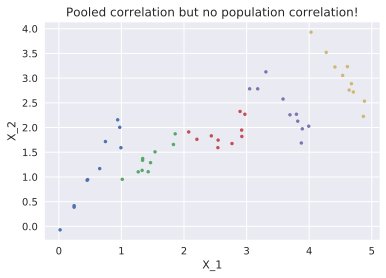

In [10]:
# Create and plot dummy data w/ pooled correlation but no population correlation
N = 10
Ns = 5
X = np.zeros((N*Ns,2))
I = np.zeros(N*Ns, dtype=int) #invididual/group number
plt.figure()
for iS in range(Ns):
    x = np.random.rand(N)
    X1 = x + iS
    X2 = x * (np.floor(Ns/2)-iS) + iS + 0.2*np.random.randn(N)
    X[iS*N:iS*N+N,0] = X1
    X[iS*N:iS*N+N,1] = X2
    I[iS*N:iS*N+N] = iS+1
    plt.plot(X1, X2, '.')
plt.title('Pooled correlation but no population correlation!')
plt.xlabel('X_1')
plt.ylabel('X_2')
plt.show()

Each color in the above plot represents samples from different individuals or groups.  Notice that if one pools the data from all individuals, there is a strong positive correlation between $X_1$ and $X_2$.  However, if we take each subject individually, two subjects show a positive correlation, two show a negative correlation, and one shows no correlation!

In [12]:
# Compute Frequentist estimates of the correlation
rho, pval = pearsonr(X[:,0], X[:,1])
print('Pooled correlation coefficient: %0.3g' % rho)
for iS in range(Ns):
    rho, pval = pearsonr(X[iS*N:iS*N+N,0], X[iS*N:iS*N+N,1])
    print('Individual %d\'s correlation coefficient: %0.3g ( p = %0.3g )' % ((iS+1), rho, pval))

Pooled correlation coefficient: 0.824
Individual 1's correlation coefficient: 0.967 ( p = 4.83e-06 )
Individual 2's correlation coefficient: 0.912 ( p = 0.000231 )
Individual 3's correlation coefficient: 0.443 ( p = 0.2 )
Individual 4's correlation coefficient: -0.871 ( p = 0.00104 )
Individual 5's correlation coefficient: -0.956 ( p = 1.5e-05 )


And running a normal Bayesian correlation doesn't fix this problem:

In [ ]:
# Data for Stan
data = {'N' : X.shape[0], #number of datapoints
        'X' : X} #the data

# Fit the model
fit = model_pc.sampling(data=data, iter=Niters, chains=Nchains, n_jobs=Nchains)

# Get the MCMC samples (draws from the posterior distribution)
samples = fit.extract()

# Plot the posterior distribution for the correlation coefficient
plt.figure()
sb.distplot(samples['rho'])
plt.xlabel('Pearson Correlation Coefficient')
plt.ylabel('Posterior Probability')
plt.show()

Now we'll define a Bayesian model in Stan which has two levels as described above.  In the first level, we'll model each datapoint as being drawn from the distribution corresponding to its individual (or group).  In the second level, we'll model each individual's $\rho$ parameter as being drawn from a population distribution.

(In a full model, one might want to also model per-subject $\mu$ parameters as being drawn from population distributions, but for the sake of simplicity we're going to skip that here.  See the [Simplifications appendix](#simplifications))

In [ ]:
#STAN code string for a two-level pearson correlation
MultilevelCorrelation = """
data {
    int<lower=0> N;    //number of datapoints
    int<lower=1> Ni;   //number of individuals/groups
    int<lower=1> I[N]; //individual of each datapoint
    vector[2] X[N];    //datapoints
}

parameters {
    vector[2] mu[Ni];               //per-individual mean
    vector<lower=0>[2] sig[Ni];     //per-individual std dev of each variable
    real<lower=-1,upper=1> rho[Ni]; //per-individual Pearson's rho
    real<lower=-1,upper=1> mu_rho;  //mean of population rhos
    real<lower=0> sig_rho;          //std dev of population rhos
}

transformed parameters {
    cov_matrix[2] C[Ni]; //covariance matrix for each individual
    for (i in 1:Ni) {
        C[i][1,1] = sig[i][1] * sig[i][1];
        C[i][1,2] = rho[i] * sig[i][1] * sig[i][2];
        C[i][2,1] = rho[i] * sig[i][1] * sig[i][2];
        C[i][2,2] = sig[i][2] * sig[i][2];
    }
}

model {
    // Each individual rho is drawn from population distribution
    rho ~ normal(mu_rho, sig_rho);
    
    // Each individual datapoint is drawn from its individual's distribution
    for (i in 1:N) {
        X[i] ~ multi_normal(mu[I[i]], C[I[i]]);
    }
}
"""

In [ ]:
# Compile the Stan model for the multilevel correlation
model_ml = pystan.StanModel(model_code=MultilevelCorrelation)

In [ ]:
# Data for Stan
data = {'N' : X.shape[0], #number of datapoints
        'Ni': len(np.unique(I)), #number of individuals
        'I' : I, #subject of each datapoint
        'X' : X} #the datapoints

# Fit the model
fit = model_ml.sampling(data=data, iter=Niters, chains=Nchains, n_jobs=Nchains)

# Get the MCMC samples (draws from the posterior distribution)
samples = fit.extract()

Now we can see how likely it is that there is a correlation between our two variables, when taking into account subject-specific differences:

In [ ]:
# Plot the posterior distribution for the correlation coefficient
plt.figure()
sb.distplot(samples['mu_rho'])
plt.xlabel('Population Mean Pearson Correlation Coefficient')
plt.ylabel('Posterior Probability')
plt.show()

As you can see, when accounting for individual differences, there's not much evidence for a correlation between our two variables.  If there were, we would expect to see a large majority of the posterior probability distribution to one side or the other of zero.  

The way the model "accounts for individual differences" is by allowing each individual to have a different parameter value.  In the two plots below, each color represents the posterior distribution for a different individual.

In [ ]:
# Plot the per-subject posterior distributions for rho
plt.figure()
for iS in range(Ns):
    sb.kdeplot(samples['rho'][:,iS], shade=True)
plt.title('Per-Individual Posterior Probability Distributions of Rho')
plt.xlabel(r'$X_1$')
plt.ylabel(r'$X_2$')
plt.show()

In [ ]:
# Plot the posterior joint distribution for the means
plt.figure(figsize=(10, 8))
cmaps = ["Blues", "Greens", "Reds", "Purples", "Oranges"]
for iS in range(Ns):
    sb.kdeplot(samples['mu'][:,iS,0], samples['mu'][:,iS,1], 
               shade=True, shade_lowest=False, cmap=cmaps[iS])
    plt.plot(X[iS*N:iS*N+N,0], X[iS*N:iS*N+N,1], '.')
plt.title('Per-Individual Joint Posterior Probability Distributions of the Means')
plt.xlabel(r'$X_1$')
plt.ylabel(r'$X_2$')
plt.show()

What about when there *is* a positive correlation at the population level, but it's not apparent if you pool the data together?  Let's create such a dataset.  We'll also decrease the number of observations per individual, so that we can see the advantages of working with multilevel models when you have very few datapoints per individual or group.

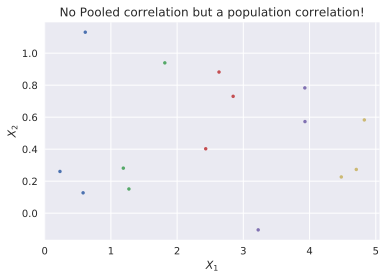

In [13]:
# Create and plot dummy data w/ no pooled correlation but a population correlation
N = 3
Ns = 5
X = np.zeros((N*Ns,2))
I = np.zeros(N*Ns, dtype=int) #invididual/group number
plt.figure()
for iS in range(Ns):
    x = np.random.rand(N)
    X1 = x + iS
    X2 = x + 0.2*np.random.randn(N) - 0.04*iS
    X[iS*N:iS*N+N,0] = X1
    X[iS*N:iS*N+N,1] = X2
    I[iS*N:iS*N+N] = iS+1
    plt.plot(X1, X2, '.')
plt.title('No Pooled correlation but a population correlation!')
plt.xlabel(r'$X_1$')
plt.ylabel(r'$X_2$')
plt.show()

Using frequentist statistics (without random effects, at least), we would see no correlation when pooling all the data together, but we also don't have enough data from each subject to be sure that the per-subject correlations are real (i.e., the power is too low - look at those awful p-values)!

In [14]:
# Compute Frequentist estimates of the correlation
rho, pval = pearsonr(X[:,0], X[:,1])
print('Pooled correlation coefficient: %0.3g ( p = %0.3g )' % (rho, pval))
for iS in range(Ns):
    rho, pval = pearsonr(X[iS*N:iS*N+N,0], X[iS*N:iS*N+N,1])
    print('Individual %d\'s correlation coefficient: %0.3g ( p = %0.3g )' % (iS+1, rho, pval))

Pooled correlation coefficient: -0.0178 ( p = 0.95 )
Individual 1's correlation coefficient: 0.461 ( p = 0.695 )
Individual 2's correlation coefficient: 0.961 ( p = 0.178 )
Individual 3's correlation coefficient: 0.656 ( p = 0.545 )
Individual 4's correlation coefficient: 0.973 ( p = 0.148 )
Individual 5's correlation coefficient: 0.839 ( p = 0.366 )


And again, using the non-multilevel Bayesian model doesn't fix this problem:

In [ ]:
# Data for Stan
data = {'N' : X.shape[0], #number of datapoints
        'X' : X} #the data

# Fit the non-multilevel model
fit = model_pc.sampling(data=data, iter=Niters, chains=Nchains, n_jobs=Nchains)

# Get the MCMC samples (draws from the posterior distribution)
samples = fit.extract()

# Plot the posterior distribution for the correlation coefficient
plt.figure()
sb.distplot(samples['rho'])
plt.xlabel('Pearson Correlation Coefficient')
plt.ylabel('Posterior Probability')
plt.show()

However, the multilevel model is able to correctly infer that there is a high probability of there being a positive correlation at the population level!

In [ ]:
# Data for Stan
data = {'N' : X.shape[0], #number of datapoints
        'Ni': len(np.unique(I)), #number of individuals
        'I' : I, #subject of each datapoint
        'X' : X} #the datapoints

# Fit the multilevel model
fit = model_ml.sampling(data=data, iter=Niters, chains=Nchains, n_jobs=Nchains)

# Get the MCMC samples (draws from the posterior distribution)
samples = fit.extract()

In [ ]:
# Plot the posterior distribution for the correlation coefficient
plt.figure()
sb.distplot(samples['mu_rho'])
plt.xlabel('Population Mean Pearson Correlation Coefficient')
plt.ylabel('Posterior Probability')
plt.show()

An additional advantage of the multilevel model is that information from the population is used to inform individuals' parameter estimates (instead of only vice-versa).  This means that even when we have a very low number of datapoints per individual, the multilevel model can have a more certain estimate of an individual's parameter values than would be obtained by fitting a model using only the data from a single individual.  (Of course, this certainty depends on the model's assumptions being true...)  Also note that this feature isn't specific to *Bayesian* multilevel models - this is just a benefit of using a mixed model where individual/group parameters are allowed to vary in a constrained way.  Notice how precise the multilevel model's per-subject estimates are:

In [ ]:
# Plot the per-subject posterior distributions for rho
plt.figure()
for iS in range(Ns):
    sb.kdeplot(samples['rho'][:,iS])
plt.title('Per-Individual Posterior Probability Distributions of Rho')
plt.xlabel('Pearson Correlation Coefficient')
plt.ylabel('Posterior Probability')
plt.title('Multilevel Model Per-Individual Estimates of Rho')
plt.show()

Whereas if we were to fit a non-multilevel model to each subject individually, our uncertainty would be much higher:

In [ ]:
# Fit the non-multilevel model for each individual, individually
plt.figure()
for iS in range(Ns):
    tX = X[iS*N:iS*N+N,:] #data for this subject
    data = {'N' : tX.shape[0],
            'X' : tX}
    fit = model_pc.sampling(data=data, iter=Niters, chains=Nchains, n_jobs=Nchains)
    samples = fit.extract()
    sb.kdeplot(samples['rho'])
plt.xlabel('Pearson Correlation Coefficient')
plt.ylabel('Posterior Probability')
plt.title('Non-Multilevel Model Per-Individual Estimates of Rho')
plt.show()

Of course you might ask: isn't that cheating?  How is it fair to use information about *other* members of a population when trying to determine information about an individual?  Isn't that... Rho-cism?  Well, no.  Racism (and sexism, and many other stereotypes and prejudices) depend on perceived population distributions which are *inaccurate*.  What if we're interested in obtaining *accurate* population and individual estimates?

From a Bayesian perspective, using the population distribution to inform your estimate of an individual is exactly the right thing to do.  Suppose the only information you have about me is a photo taken from 2 miles away (in addition to the fact that I'm a human...), and you want to determine my height.  I only occupy 1 pixel of the photograph, so your uncertainty as to my height is extremely high.  However, knowing that I'm a member of a given population (i.e. the population of all humans), makes you *pretty sure* I'm between 4 and 8 feet tall, because you know the distribution of heights for other members of that population.  I'd have to be pretty large in that photograph to convince you that I was any larger than, say, 10 feet tall.  But if you had 100 photographs all where I looked 11 feet tall, then you'd have to give more weight to that data than to what you knew about the population distribution.  And if you start seeing lots of photographs of lots of other 11-foot-tall people, you might want to update what you consider the population distribution.

In a multilevel model, we allow the population distribution to act as a [prior](https://en.wikipedia.org/wiki/Prior_probability) on our estimate of the parameters for each individual.  If we don't have any information about an individual, the multilevel model just assumes that individual's parameters are more likely to be close to the population mean (or more accurately, to follow the population distribution).  But given more and more data from a specific individual, that individual's estimate is pulled away from the population distribution towards the value that the observations indicate. 

The key here is that we're estimating each individual's parameters using the population distribution as a prior, while *at the same time* estimating the population distribution from the individuals' parameters!

[![AT THE SAME TIME!!!](https://media1.tenor.com/images/b2190afe666915580adb0890260362d1/tenor.gif?itemid=4895431)](https://tenor.com/view/mind-blown-bill-nye-science-guy-explosions-incredible-gif-4895431)

Next, we'll see how we can tweak our correlation to deal with outliers (via robust correlations).

## Robust Correlation
<a class="anchor" id="robust-correlation"></a>

One problem with using normal distributions in a model is that they don't handle outliers very well.  That is, they assign more weight to observations which lie far away from the mean than maybe they should.  For example, suppose we gather test scores from 20 children, and around 68% of the scores are between 80 and 100, but Jimmy's score is 20.  A normal distribution centered at 90 with a standard deviation of 10 would put the odds of getting Jimmy's score at around one in 309 billion.  But that's *really* unlikely.  Like, *ludicrously* unlikely.  That would imply that Jimmy is literally the dumbest human on Earth.  That's probably not the case.  Jimmy was probably just zoning out.  The effect of this is that when we use normal distributions to model data, outliers have a huge effect on our estimates.

The reason normal distributions assign so much weight to outliers is because they're a so-called "light-tailed distribution", meaning that the "tails" or edges of the distribution have a very low percentage of the probability mass, while the vast majority of the probability mass is centered close to the mean.  What we can use instead is a "heavy-tailed" distribution, whose tails aren't as ludicrously unlikely, but are still less likely than values at the center.  A commonly used heavy-tailed distribution is the [t-distribution](https://en.wikipedia.org/wiki/Student%27s_t-distribution).  As you can see below, this distribution doesn't assign as ludicrously low probabilities to outliers - but outliers still have a lower probability than observations around the mean.




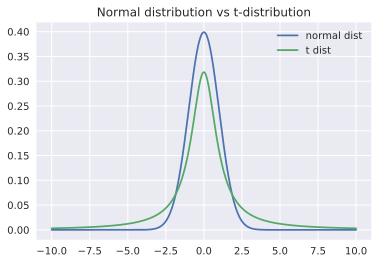

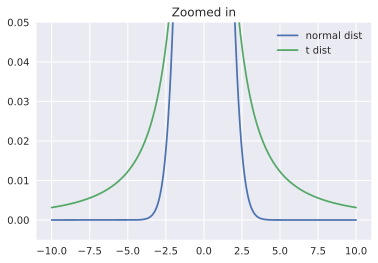

In [17]:
# Plot normal distribution vs t-distribution
from scipy.stats import norm, t
x = np.arange(-10, 10, 0.001)
p_normal = norm.pdf(x,0,1)
p_tdist = t.pdf(x,1,0,1)

plt.figure()
nd = plt.plot(x, p_normal, label='normal dist')
td = plt.plot(x, p_tdist, label='t dist')
plt.title('Normal distribution vs t-distribution')
plt.legend()
plt.show()

plt.figure()
nd = plt.plot(x, p_normal, label='normal dist')
td = plt.plot(x, p_tdist, label='t dist')
plt.ylim((-0.005, 0.05))
plt.title('Zoomed in')
plt.legend()
plt.show()

We can replace the normal distributions in our Bayesian model with t-distributions to ensure that outliers don't have such a huge effect on our estimates.  Let's replace the multivariate normal distribution in the first level of our model with a multivariate t-distribution.  That way, if an individual has datapoints which are outliers, it won't effect our estimate of that individual's parameter as much.

In the second level of our Bayesian model, we could also also replace the population normal distribution with a t-distribution.  That way, if any of the *individuals* are an outlier, our estimate of the population distribution won't be overly skewed by that single individual.  For example, if all individuals showed a small positive correlation, but one individual showed a strong negative correlation, using a t-distribution would allow our model to let that individual's $\rho$ be negative, while still maintaining a positive estimate of $\rho$ across the population.  However, we'll keep using a normal distribution for now for simplicity (but see the [Simplifications appendix](#simplifications) for more details).

Let's create a multilevel Bayesian correlation model in Stan which uses a t-distribution at the lowest level instead of a normal distribution.  This will allow for estimates which are more robust (to outliers).  The only change we'll make here is to switch `normal(...)` to `multi_student_t(1,...)`.

(Note that the degrees of freedom of the t distributions could also be free parameters, but we'll just use DOF=1 here for simplicity.  See the [Simplifications appendix](#simplifications))

In [18]:
#STAN code string for a robust two-level Pearson correlation
RobustCorrelation = """
data {
    int<lower=0> N;    //number of datapoints
    int<lower=1> Ni;   //number of individuals/groups
    int<lower=1> I[N]; //individual of each datapoint
    vector[2] X[N];    //datapoints
}

parameters {
    vector[2] mu[Ni];               //per-individual mean
    vector<lower=0>[2] sig[Ni];     //per-individual std dev of each variable
    real<lower=-1,upper=1> rho[Ni]; //per-individual Pearson's rho
    real<lower=-1,upper=1> mu_rho;  //mean of population rhos
    real<lower=0> sig_rho;          //std dev of population rhos
}

transformed parameters {
    cov_matrix[2] C[Ni]; //covariance matrix for each individual
    for (i in 1:Ni) {
        C[i][1,1] = sig[i][1] * sig[i][1];
        C[i][1,2] = rho[i] * sig[i][1] * sig[i][2];
        C[i][2,1] = rho[i] * sig[i][1] * sig[i][2];
        C[i][2,2] = sig[i][2] * sig[i][2];
    }
}

model {
    // Each individual rho is drawn from population distribution
    rho ~ normal(mu_rho, sig_rho);

    // Each individual datapoint is drawn from its individual's distribution
    for (i in 1:N) {
        X[i] ~ multi_student_t(1, mu[I[i]], C[I[i]]);
    }
}
"""

In [19]:
# Compile the Stan model for the robust multilevel correlation
model_rml = pystan.StanModel(model_code=RobustCorrelation)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5062b759443252cfd1aa0f9505a9e71e NOW.


Let's create some dummy data where we KNOW there's a correlation at the population level, but some subjects have measurements which are outliers. 

In [ ]:
# Create and plot dummy data w/ no pooled correlation but a population correlation
N = 5
Ns = 5
X = np.zeros((N*Ns,2))
I = np.zeros(N*Ns, dtype=int) #invididual/group number
plt.figure()
for iS in range(Ns):
    x = np.random.rand(N)
    X1 = x + iS
    X2 = x + 0.1*np.random.randn(N) - 0.04*iS
    if iS==0: #individual 1 has an outlier measurement
        X1[0] = 3
        X2[0] = -3
    elif iS==1: #so does individual 2
        X1[0] = 4
        X2[0] = -4
    X[iS*N:iS*N+N,0] = X1
    X[iS*N:iS*N+N,1] = X2
    I[iS*N:iS*N+N] = iS+1
    plt.plot(X1, X2, '.')
plt.title('Positive population correlation, but with outliers!')
plt.xlabel(r'$X_1$')
plt.ylabel(r'$X_2$')
plt.show()

And now we can fit the robust correlation to that data:

In [ ]:
# Fit the Stan model
data = {'N' : X.shape[0], #number of datapoints
        'Ni': len(np.unique(I)), #number of individuals
        'I' : I, #subject of each datapoint
        'X' : X} #the datapoints
fit = model_rml.sampling(data=data, iter=Niters, chains=Nchains, n_jobs=Nchains)
samples = fit.extract()

# Plot the posterior distribution for the population correlation coefficient
plt.figure()
sb.distplot(samples['mu_rho'])
plt.title('Robust Estimate of Rho across the Population')
plt.xlabel('Population Mean Pearson Correlation Coefficient')
plt.ylabel('Posterior Probability')
plt.show()

# Plot the per-subject posterior distributions for rho
plt.figure()
for iS in range(Ns):
    sb.kdeplot(samples['rho'][:,iS])
plt.title('Per-Individual Posterior Probability Distributions of Rho')
plt.xlabel('Pearson Correlation Coefficient')
plt.ylabel('Posterior Probability')
plt.title('Robust Per-Individual Estimates of Rho')
plt.show()

Notice that despite those outliers, the robust correlation is pretty sure there's a positive correlation at the population level.  However, when we run the non-robust model, those two datapoints have a *huge* impact on the fit, and the model doesn't find much evidence for a correlation at all!

In [ ]:
# Fit the Stan model
data = {'N' : X.shape[0], #number of datapoints
        'Ni': len(np.unique(I)), #number of individuals
        'I' : I, #subject of each datapoint
        'X' : X} #the datapoints
fit = model_ml.sampling(data=data, iter=Niters, chains=Nchains, n_jobs=Nchains)
samples = fit.extract()

# Plot the posterior distribution for the population correlation coefficient
plt.figure()
sb.distplot(samples['mu_rho'])
plt.title('NON-Robust Estimate of Rho across the Population')
plt.xlabel('Population Mean Pearson Correlation Coefficient')
plt.ylabel('Posterior Probability')
plt.show()

# Plot the per-subject posterior distributions for rho
plt.figure()
for iS in range(Ns):
    sb.kdeplot(samples['rho'][:,iS])
plt.title('Per-Individual Posterior Probability Distributions of Rho')
plt.xlabel('Pearson Correlation Coefficient')
plt.ylabel('Posterior Probability')
plt.title('NON-Robust Per-Individual Estimates of Rho')
plt.show()

This is why robust models are often better for fitting data which contains outliers - the model will still capture the patterns in your data, but without assigning so much weight to observations which have ridiculous values.

Of course, the decision to use a robust model depends on our data and analysis situation - we don't just want to use a robust model all the time blindly.  If the data has outliers, and we suspect those outliers are due to flukes or causes unrelated to what we're trying to model, then using a robust correlation is probably the way to go.  On the other hand, if we suspect those "outliers" may be valid observations, then those observations might be providing strong evidence, and we'll want to use a non-robust model.

<a class="anchor" id="real-data"></a>
## Correlating School Funding with Student Performance

When would one want to use a Bayesian multilevel model in a real-world situation?  As an example, we can use our multilevel Bayesian correlation to determine whether school funding is correlated with the performance and progress of its students.

We'll be using a dataset which contains information about K-12 schools in Massachusetts, and is [available from the Massachusetts Department of Education](http://profiles.doe.mass.edu/state_report/).  The dataset contains information about each K-12 school in Massachusetts, including how much money the school spent per student, a score of student progress and performance, and the location of the school.  

We want to determine if there is a correlation between the amount of money spent for education per student and the performance or progress of the students at a school.  However, we also want to account for geographical differences between the populations of students.  So, we'll fit a robust multilevel Bayesian correlation with ZIP code as the grouping variable (just like we used individual as the grouping variable in the examples before).  However, there's only about 4 schools on average per ZIP code (and some ZIPs have only 1 school!), so for practical reasons we'll group schools by the first 3 digits of their ZIP code. 

Note that to answer the *causal* question "does increased funding *cause* an increase in student performance?", one would need to run a controlled experiment (e.g. randomly select schools to give more money, and monitor the outcomes), and then fit a regression model.  Correlations can't answer causal questions, but if there's no correlation in the data, it's less likely that there's a causal relationship.  So a reasonable first step before designing an experiment to answer a causal question is to first confirm that there is a correlation in the observational data.

In [20]:
# Load Massachusetts Public School data
df = pd.read_csv('../input/MA_Public_Schools_2017.csv')

In [21]:
# Take a look at the data
df.sample(n=5)

,School Code,School Name,School Type,Function,Contact Name,Address 1,Address 2,Town,State,Zip,Phone,Fax,Grade,District Name,District Code,PK_Enrollment,K_Enrollment,1_Enrollment,2_Enrollment,3_Enrollment,4_Enrollment,5_Enrollment,6_Enrollment,7_Enrollment,8_Enrollment,9_Enrollment,10_Enrollment,11_Enrollment,12_Enrollment,SP_Enrollment,TOTAL_Enrollment,First Language Not English,% First Language Not English,English Language Learner,% English Language Learner,Students With Disabilities,% Students With Disabilities,High Needs,% High Needs,Economically Disadvantaged,...,MCAS_7thGrade_English_CPI,MCAS_7thGrade_English_SGP,MCAS_7thGrade_English_Incl. in SGP(#),MCAS_8thGrade_English_P+A #,% MCAS_8thGrade_English_P+A,MCAS_8thGrade_English_A #,% MCAS_8thGrade_English_A,MCAS_8thGrade_English_P #,% MCAS_8thGrade_English_P,MCAS_8thGrade_English_NI #,% MCAS_8thGrade_English_NI,MCAS_8thGrade_English_W/F #,% MCAS_8thGrade_English_W/F,MCAS_8thGrade_English_Stud. Incl. #,MCAS_8thGrade_English_CPI,MCAS_8thGrade_English_SGP,MCAS_8thGrade_English_Incl. in SGP(#),MCAS_10thGrade_English_P+A #,% MCAS_10thGrade_English_P+A,MCAS_10thGrade_English_A #,% MCAS_10thGrade_English_A,MCAS_10thGrade_English_P #,% MCAS_10thGrade_English_P,MCAS_10thGrade_English_NI #,% MCAS_10thGrade_English_NI,MCAS_10thGrade_English_W/F #,% MCAS_10thGrade_English_W/F,MCAS_10thGrade_English_Stud. Incl. #,MCAS_10thGrade_English_CPI,MCAS_10thGrade_English_SGP,MCAS_10thGrade_English_Incl. in SGP(#),Accountability and Assistance Level,Accountability and Assistance Description,School Accountability Percentile (1-99),Progress and Performance Index (PPI) - All Students,Progress and Performance Index (PPI) - High Needs Students,District_Accountability and Assistance Level,District_Accountability and Assistance Description,District_Progress and Performance Index (PPI) - All Students,District_Progress and Performance Index (PPI) - High Needs Students
600,1010040,Annie Sullivan Middle School,Public School,Principal,Beth Wittcoff,500 Lincoln Street,NaN,Franklin,MA,2038,508-553-0322,508-541-2109,"06,07,08",Franklin,1010000,0,0,0,0,0,0,0,158,154,152,0,0,0,0,0,464,17.0,3.7,4.0,0.9,79.0,17.0,106.0,22.8,35.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Level 2,Not meeting gap narrowing goals,71.0,69.0,39.0,Level 2,One or more schools in the district classified...,78.0,58.0
159,350200,Harvard-Kent,Public School,Principal,Jason Gallagher,50 Bunker Hill Street,NaN,Charlestown,MA,2129,617-635-8358,617-635-8364,"PK,K,01,02,03,04,05",Boston,350000,38,54,58,77,108,94,66,0,0,0,0,0,0,0,0,495,279.0,56.4,233.0,47.1,107.0,21.6,452.0,91.3,369.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Level 1,Meeting gap narrowing goals,22.0,79.0,79.0,Level 4,One or more schools in the district classified...,53.0,54.0
371,710030,Riverside,Public School,Principal,Violetta Powers,95 Liberty Street,NaN,Danvers,MA,1923,978-774-5010,978-774-7850,"PK,K,01,02,03,04,05",Danvers,710000,46,12,37,53,47,45,38,0,0,0,0,0,0,0,0,278,9.0,3.2,7.0,2.5,82.0,29.5,125.0,45.0,60.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Level 1,Meeting gap narrowing goals,35.0,77.0,76.0,Level 2,One or more schools in the district classified...,58.0,52.0
1042,1910505,Monson High School,Public School,Principal,William Metzger,55 Margaret Street,NaN,Monson,MA,1057,413-267-4589,413-267-4157,"09,10,11,12",Monson,1910000,0,0,0,0,0,0,0,0,0,0,63,73,68,83,0,287,4.0,1.4,0.0,0.0,25.0,8.7,65.0,22.6,49.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59.0,87.0,35.0,51.0,24.0,35.0,6.0,9.0,3.0,4.0,68.0,94.5,34.0,63.0,Level 2,Not meeting gap narrowing goals,25.0,64.0,NaN,Level 3,One or more schools in the district classified...,72.0,71.0
1435,2780505,South Hadley High,Public School,Principal,Diana Bo

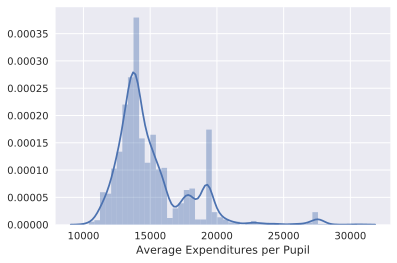

Number of nan Expenditures 93
Percent nan Expenditures 4.997313272434175


In [22]:
# Plot distribution of Expenditures per Pupil
costs = df['Average Expenditures per Pupil']
sb.distplot(costs.dropna())
plt.show()

# Print the number of empty entries for this column
print('Number of nan Expenditures', costs.isnull().sum())
print('Percent nan Expenditures', 100*costs.isnull().sum()/df.shape[0])

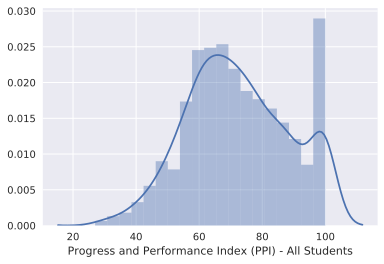

Number of nan PPI 270
Percent nan PPI 14.508328855454057


In [23]:
# Plot distribution of progres and performance
ppi = df['Progress and Performance Index (PPI) - All Students']
sb.distplot(ppi.dropna())
plt.show()

# Print the number of empty entries for this column
print('Number of nan PPI', ppi.isnull().sum())
print('Percent nan PPI', 100*ppi.isnull().sum()/df.shape[0])

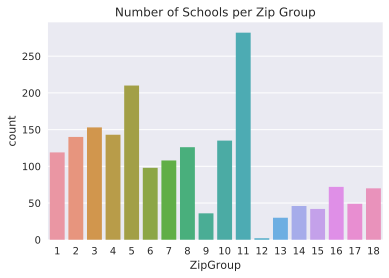

In [24]:
# Group schools by 1st 3 digits of zip code
df['ZipGroup'], _ = pd.factorize(df['Zip'].apply(lambda x: ("%05d" % x)[:3]))
df['ZipGroup'] = df['ZipGroup'] + 1 #start indexing at 1

# Plot the number of schools per zip group
plt.figure()
sb.countplot(x='ZipGroup', data=df)
plt.title('Number of Schools per Zip Group')
plt.show()

Let's plot school expenditures per student against each school's performance index to see if there is an obvious correlation.

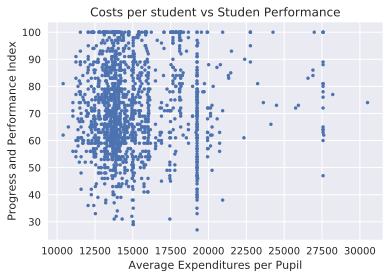

In [25]:
# Plot school expenditures per pupil against the performance index
plt.figure()
plt.plot(costs, ppi, '.')
plt.xlabel('Average Expenditures per Pupil')
plt.ylabel('Progress and Performance Index')
plt.title('Costs per student vs Studen Performance')
plt.show()

It looks like there *might* be a correlation there - especially given the performance index of schools which are spending over $20,000 per student.  But again, that could be due to geographic differences.  What if all the points in the upper-right of the above plot are simply due to a few well-off school districts, where students perform better because of less financial stress, and those districts are able to spend more per student because of higher tax revenues?  We want to know if there's a correlation between costs and performance *within* each school district.  Therefore we want to use our multilevel Bayesian correlation to determine if there is a correlation, on average, for each region individually.

We'll cheat a bit here and define a new model which is the same as our previous "robust" multilevel correlation, except there is only one mean parameter.  In theory we would want to allow the mean for each group be different, but in a constrained way!  See the [Simplifications appendix](#simplifications) for more about that, and how to do it the right way.

In [77]:
#STAN code string for a robust two-level Pearson correlation with priors!
RobustCorrelation = """
data {
    int<lower=0> N;    //number of datapoints
    int<lower=1> Ni;   //number of individuals/groups
    int<lower=1> I[N]; //individual of each datapoint
    vector[2] X[N];    //datapoints
}

parameters {
    vector[2] mu;                   //mean
    vector<lower=0>[2] sig;         //std dev of each variable
    real<lower=-1,upper=1> rho[Ni]; //per-individual Pearson's rho
    real<lower=-1,upper=1> mu_rho;  //mean of population rhos
    real<lower=0> sig_rho;          //std dev of population rhos
}

transformed parameters {
    cov_matrix[2] C[Ni]; //covariance matrix for each individual
    for (i in 1:Ni) {
        C[i][1,1] = sig[1] * sig[1];
        C[i][1,2] = rho[i] * sig[1] * sig[2];
        C[i][2,1] = rho[i] * sig[1] * sig[2];
        C[i][2,2] = sig[2] * sig[2];
    }
}

model {    
    // Each individual rho is drawn from population distribution
    rho ~ normal(mu_rho, sig_rho);

    // Each individual datapoint is drawn from its individual's distribution
    for (i in 1:N) {
        X[i] ~ multi_student_t(1, mu, C[I[i]]);
    }
}
"""

In [78]:
# Compile the Stan model for the robust multilevel correlation
model_rml = pystan.StanModel(model_code=RobustCorrelation)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ffb6bef97eeb87aacbba2b1bbbafc090 NOW.


In [83]:
# Only keep schools which have both expenditures and performance data
datacols = ['Average Expenditures per Pupil',
            'Progress and Performance Index (PPI) - All Students']
sdf = df.dropna(subset=datacols)

# Normalize data
for col in datacols:
    sdf[col] = (sdf[col] - np.mean(sdf[col]))/np.std(sdf[col])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [80]:
# things to help convergence: 
# more chains? - NOPE 
# init all at same value? - NOPE
# informative priors - NOPE
# normalizing - NOPE
# normal bayesian correlation works just fine...
# only 1 mean param? - yeah that helps
# draw means from pop dist? - 

#Nchains = 4
#Niters = 100

# Fit the Stan model
data = {'N' : sdf.shape[0], #number of schools
        'Ni': len(sdf['ZipGroup'].unique()), #number of zip groups
        'I' : sdf['ZipGroup'], #zip group index of each school
        'X' : sdf.as_matrix(columns=datacols)} #the datapoints
model_pc
fit = model_rml.sampling(data=data, iter=Niters, chains=Nchains, n_jobs=Nchains)
samples = fit.extract()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:38: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/opt/conda/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


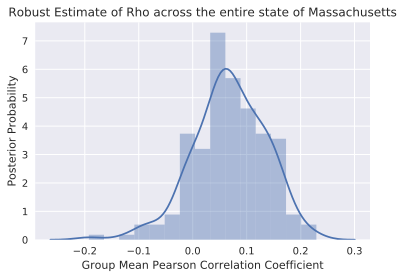

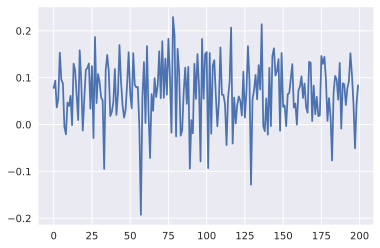

In [82]:
# Plot the posterior distribution for the across-group mean correlation coefficient
plt.figure()
sb.distplot(samples['mu_rho'])
plt.title('Robust Estimate of Rho across the entire state of Massachusetts')
plt.xlabel('Group Mean Pearson Correlation Coefficient')
plt.ylabel('Posterior Probability')
plt.show()

plt.figure()
plt.plot(samples['mu_rho'])
plt.show()

TODO: INTERPERETATION

So there's pretty strong evidence that across the entire state of Massachusetts, on average, there is a correlation between the amount of money spent per student and the performance of those students.  But because this is a multilevel model, we get estimates not only for the state-level correlation, but also for schools in each ZIP group.  If we were a decision-maker at, say, the district level, we would want to use the estimate relevant to our district instead of the state average.  Notice that some ZIP groups actually have significant evidence for a *negative* correlation!

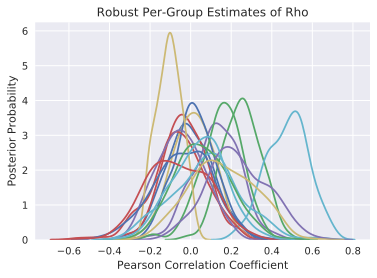

In [84]:
# Plot the per-group posterior distributions for rho
plt.figure()
for iS in range(len(sdf['ZipGroup'].unique())):
    sb.kdeplot(samples['rho'][:,iS])
plt.title('Posterior Probability Distributions of Rho for each ZIP group')
plt.xlabel('Pearson Correlation Coefficient')
plt.ylabel('Posterior Probability')
plt.title('Robust Per-Group Estimates of Rho')
plt.show()

TODO: CONCLUSION

<a class="anchor" id="simplifications"></a>
## Simplifications

The models above were a bit simplified so as not to distract from the main idea of a multilevel correlation model.  Here are some ways in which they were simplified, and how to un-simplify them for a better model!

### Population distribution for the means

The simplified model included only a population distribution for the correlation coefficient ($\rho$), but not for the means ($\mu$)!   With a more complete model, especially if we're modeling many individuals/groups with not many datapoints per individual/group, we should model each individual's mean as being drawn from a population distribution.  We could use a multivariate t-distribution to model the population distribution of means in a robust way.  That way, given less information about an individual, we'll assume the mean of their data lies closer to the population mean, but with more datapoints from that individual, their mean will more closely reflect the actual mean of their datapoints.

![Means of per-individual distributions are drawn from a population distribution](https://brendanhasz.github.io/assets/img/bayesian-correlation/population-mean-distribution.svg)


### Degrees of freedom parameter for the t-distributions

In addition to parameters which control the mean variance, t-distributions have an additional parameter, $\nu$, which controls the degrees of freedom (DOF) of the distribution.  Lower values of $\nu$ give more heavy-tailed distributions, where higher values of $\nu$ yeild distributions which are closer to the shape of a normal distribution, with lighter tails.

In [ ]:
# Plot t-distributions with different degrees of freedom
from scipy.stats import norm, t
x = np.arange(-5, 5, 0.001)
plt.figure()
for iNu in [1, 2, 5, 100]:
    p_tdist1 = t.pdf(x,iNu,0,1)
    plt.plot(x, p_tdist1, label=r'$\nu='+str(iNu)+r'$')
p_normal = norm.pdf(x,0,1)
nd = plt.plot(x, p_normal, '--', label='Normal dist')
plt.xlim((-5, 5))
plt.xlabel('Value')
plt.ylabel('Probability')
plt.title(r't-distributions with different $\nu$ values')
plt.legend()
plt.show()


In the models above, we just set $\nu=1$ for all distributions, but we could leave the parameter as a free parameter and allow it to take whichever value best explains our data.  So we would have one $\nu_p$ parameter for the population mean t-distribution, and each individual would have their own $\nu_i$ parameter for that individual's t-distribution.  To constrain the individual $\nu_i$s, we could add a "second level" and model those values as being drawn from a population distribution (e.g. a [gamma distribution](https://en.wikipedia.org/wiki/Gamma_distribution)).


### Beta distribution for population $\rho$ distribution

Another simplification is using a normal distribution as the population distribution for the per-subject $\rho$s.  A normal distribution is unbounded - that is, it takes values which range from $-\infty$ to $\infty$.  On the other hand, the value of $\rho$ only ranges from $-1$ to $1$! Since it's impossible for $\rho$ to take values outside that range, we should use a distribution which can only take values between $-1$ and $1$.  For this we could use a [beta distribution](https://en.wikipedia.org/wiki/Beta_distribution), but we'd want to scale it to take values between $-1$ and $1$ (a vanilla beta distribution takes values between $0$ and $1$).  

In Stan, we would want to use mean and variance parameters for this population $\rho$ distribution so that we could see the posterior distribution of the mean of *that* distribution.  But beta distributions in stan are parameterized by $\alpha$ and $\beta$ parameters, so in the transformed parameters block we would have to compute the $\alpha$ and $\beta$ parameters of the beta distribution from the mean and variance.


### Priors!

An important part of Baysian modelling which we didn't talk about is the use of priors!  In a Bayesian model, the prior corresponds to the distribution of a parameter which you suspect to be true *prior to* seeing any of the data.  Whereas the posterior distribution is what your prior distribution should change to *after* seeing the data.  We're going to add some weakly informative priors to the model as well.  

A lot of people get uppity about using weakly informative priors (they prefer no priors or non-informative priors) because they feel that they bias the result towards your prior.  They're right about that - using a prior does bias the resulting posterior distribution in favor of the prior.  However, there's a few reasons why using weakly informative prior distributions are a good idea.  

First of all, with a decent amount of data, the data will far outweigh your priors.  I've found that for most of the models I've fit in Stan with more than around 10,000 datapoints, changing my prior basically has no effect on the posterior.  Of course, this depends on your model, and the less data you use, the larger the effect of your prior will be.

Secondly, the use of priors in Bayesian statistics is really just explicitly stating your expectations.  Non-explicit priors have an effect on one's results even when using frequentist statistics!  If the result you get from a frequentist analysis is completely different from what you expect, you'll be dubious as to the validity of that finding.  In many cases, one may even perform the analysis in a different way, collect more data, etc.  Using a prior in a Bayesian model simply provides a mathematical way to express what you *expect* the answer to look like, and then the posterior incorporates that expectation.  That way the posterior distribution reflects how likely you, as an objective Bayesian observer, should judge the parameter's value given what you thought before *and* given the data.

For more info about weakly informative priors and which ones to use, check out the [Stan wiki](http://andrewgelman.com/2011/12/27/keeping-things-unridiculous-berger-ohagan-and-me-on-weakly-informative-priors/) which has some suggestions.